# Gaussian Processes

In [1]:
from d2l import torch as d2l
import numpy as np
from scipy.spatial import distance_matrix
from scipy import optimize
import matplotlib.pyplot as plt
import math
import torch
import gpytorch
import os

d2l.set_figsize()

C:\Users\braun\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


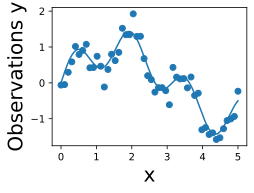

In [2]:
def data_maker1(x, sig):
    return np.sin(x) + 0.5 * np.sin(4 * x) + np.random.randn(x.shape[0]) * sig

sig = 0.25
train_x, test_x = np.linspace(0, 5, 50), np.linspace(0, 5, 500)
train_y, test_y = data_maker1(train_x, sig=sig), data_maker1(test_x, sig=0.)

d2l.plt.scatter(train_x, train_y)
d2l.plt.plot(test_x, test_y)
d2l.plt.xlabel("x", fontsize=20)
d2l.plt.ylabel("Observations y", fontsize=20)
d2l.plt.show()

In [3]:
mean = np.zeros(test_x.shape[0])
cov = d2l.rbfkernel(test_x, test_x, ls=0.2)

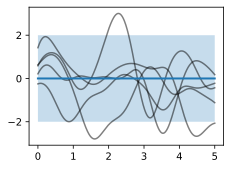

In [5]:
prior_samples = np.random.multivariate_normal(mean=mean, cov=cov, size=5)
d2l.plt.plot(test_x, prior_samples.T, color='black', alpha=0.5)
d2l.plt.plot(test_x, mean, linewidth=2.)
d2l.plt.fill_between(test_x, mean - 2 * np.diag(cov), mean + 2 * np.diag(cov), 
                 alpha=0.25)
d2l.plt.show()

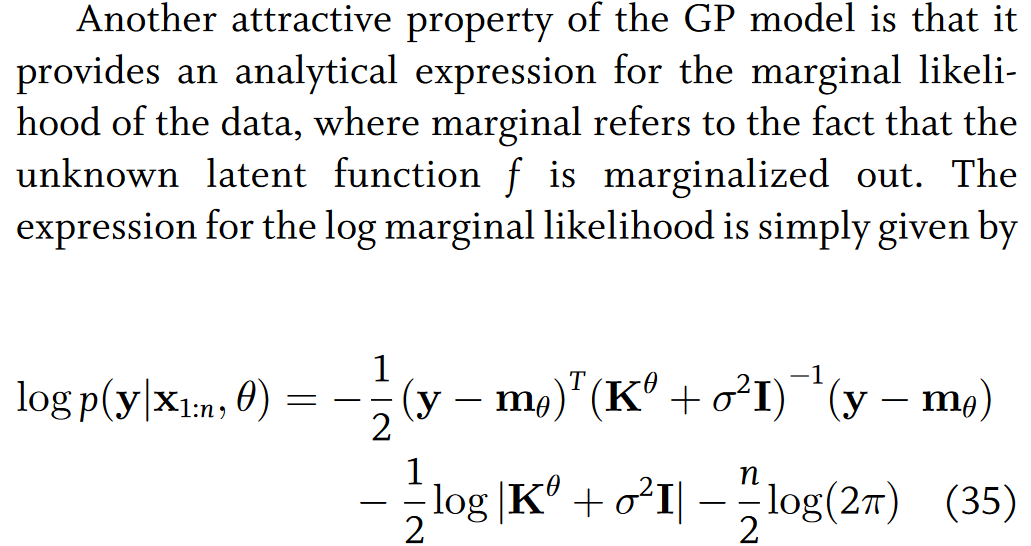

In [7]:
ell_est = 0.4
post_sig_est = 0.5

def neg_MLL(pars):
    K = d2l.rbfkernel(train_x, train_x, ls=pars[0])
    kernel_term = -0.5 * train_y @ \
        np.linalg.inv(K + pars[1] ** 2 * np.eye(train_x.shape[0])) @ train_y
    logdet = -0.5 * np.log(np.linalg.det(K + pars[1] ** 2 * \
                                         np.eye(train_x.shape[0])))
    const = -train_x.shape[0] / 2. * np.log(2 * np.pi)
    
    return -(kernel_term + logdet + const)


learned_hypers = optimize.minimize(neg_MLL, x0=np.array([ell_est,post_sig_est]), 
                                   bounds=((0.01, 10.), (0.01, 10.)))
ell = learned_hypers.x[0]
post_sig_est = learned_hypers.x[1]
ell, post_sig_est

(0.28672566027774604, 0.23186964202789534)

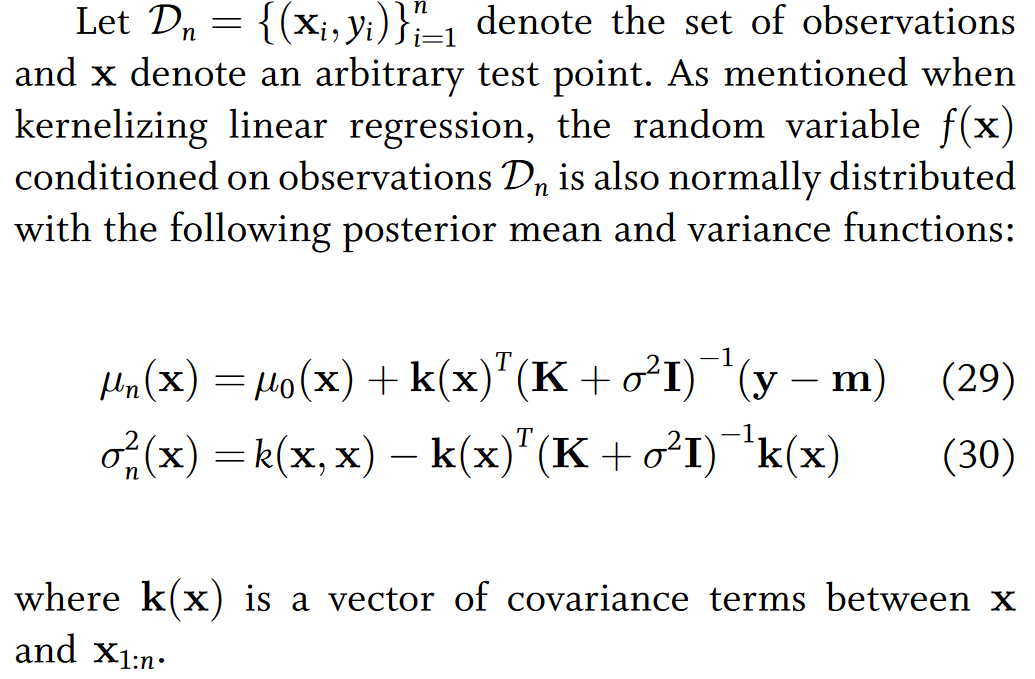

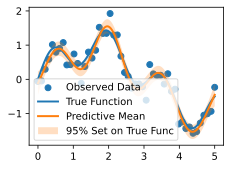

In [8]:
K_x_xstar = d2l.rbfkernel(train_x, test_x, ls=ell)
K_x_x = d2l.rbfkernel(train_x, train_x, ls=ell)
K_xstar_xstar = d2l.rbfkernel(test_x, test_x, ls=ell)

post_mean = K_x_xstar.T @ np.linalg.inv((K_x_x + \
                post_sig_est ** 2 * np.eye(train_x.shape[0]))) @ train_y
post_cov = K_xstar_xstar - K_x_xstar.T @ np.linalg.inv((K_x_x + \
                post_sig_est ** 2 * np.eye(train_x.shape[0]))) @ K_x_xstar

lw_bd = post_mean - 2 * np.sqrt(np.diag(post_cov))
up_bd = post_mean + 2 * np.sqrt(np.diag(post_cov))

d2l.plt.scatter(train_x, train_y)
d2l.plt.plot(test_x, test_y, linewidth=2.)
d2l.plt.plot(test_x, post_mean, linewidth=2.)
d2l.plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25)
d2l.plt.legend(['Observed Data', 'True Function', 'Predictive Mean', '95% Set on True Func'])
d2l.plt.show()

In [12]:
lw_bd_observed = post_mean - 2 * np.sqrt(np.diag(post_cov) + post_sig_est ** 2)
up_bd_observed = post_mean + 2 * np.sqrt(np.diag(post_cov) + post_sig_est ** 2)

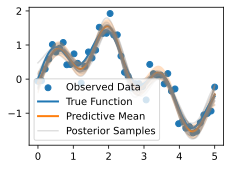

In [13]:
post_samples = np.random.multivariate_normal(post_mean, post_cov, size=20)
d2l.plt.scatter(train_x, train_y)
d2l.plt.plot(test_x, test_y, linewidth=2.)
d2l.plt.plot(test_x, post_mean, linewidth=2.)
d2l.plt.plot(test_x, post_samples.T, color='gray', alpha=0.25)
d2l.plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25)
plt.legend(['Observed Data', 'True Function', 'Predictive Mean', 'Posterior Samples'])
d2l.plt.show()

In [14]:
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)

# We are using exact GP inference with a zero mean and RBF kernel
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [15]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
training_iter = 50
# Find optimal model hyperparameters
model.train()
likelihood.train()
# Use the adam optimizer, includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  
# Set our loss as the negative log GP marginal likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [16]:
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i % 10 == 0:
        print(f'Iter {i+1:d}/{training_iter:d} - Loss: {loss.item():.3f} '
              f'squared lengthscale: '
              f'{model.covar_module.base_kernel.lengthscale.item():.3f} '
              f'noise variance: {model.likelihood.noise.item():.3f}')
    optimizer.step()

Iter 1/50 - Loss: 1.015 squared lengthscale: 0.693 noise variance: 0.693
Iter 11/50 - Loss: 0.725 squared lengthscale: 0.437 noise variance: 0.312
Iter 21/50 - Loss: 0.467 squared lengthscale: 0.495 noise variance: 0.127
Iter 31/50 - Loss: 0.358 squared lengthscale: 0.507 noise variance: 0.056
Iter 41/50 - Loss: 0.374 squared lengthscale: 0.511 noise variance: 0.041


c:\Users\braun\anaconda3\envs\torch\lib\site-packages\gpytorch-1.5.1-py3.9.egg\gpytorch\lazy\triangular_lazy_tensor.py:124: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


In [18]:
# Get into evaluation (predictive posterior) mode
test_x = torch.tensor(test_x)
model.eval()
likelihood.eval()
observed_pred = likelihood(model(test_x)) 

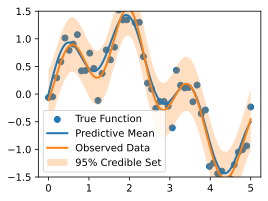

In [19]:
with torch.no_grad():
    # Initialize plot
    f, ax = d2l.plt.subplots(1, 1, figsize=(4, 3))
    # Get upper and lower bounds for 95\% credible set (in this case, in
    # observation space)
    lower, upper = observed_pred.confidence_region()
    ax.scatter(train_x.numpy(), train_y.numpy())
    ax.plot(test_x.numpy(), test_y.numpy(), linewidth=2.)
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), linewidth=2.)
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.25)
    ax.set_ylim([-1.5, 1.5])
    ax.legend(['True Function', 'Predictive Mean', 'Observed Data',
               '95% Credible Set'])